In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from collections import Counter
import math

import shapely as shp
from shapely.geometry import box, LineString, Point
from shapely.affinity   import rotate
from shapely.ops        import unary_union
import osmnx as ox

import nomad.io.base as loader
import nomad.city_gen as cg
import nomad.traj_gen as tg
from nomad.city_gen import City, Building, Street
from nomad.traj_gen import Agent

In [3]:
def simplify_streets(
    streets_gdf: gpd.GeoDataFrame,
    clip_poly,                    
    grid_size:    float = 10.0,
    rotation_deg: float = 9.0,
    max_extend:   float = None,
) -> gpd.GeoDataFrame:
    if max_extend is None:
        max_extend = grid_size

    clip = clip_poly.unary_union if hasattr(clip_poly, "unary_union") else clip_poly
    cx, cy = clip.centroid.x, clip.centroid.y

    # 1) rotate & explode
    df = streets_gdf.copy()
    df["geometry"] = df.geometry.map(lambda g: rotate(g, rotation_deg, origin=(cx, cy)))
    df = df.explode(ignore_index=True).loc[lambda d: d.geometry.geom_type=="LineString"]

    # 2) snap to grid
    def _snap(line):
        xs, ys = zip(*line.coords)
        xs = np.round(np.array(xs)/grid_size)*grid_size
        ys = np.round(np.array(ys)/grid_size)*grid_size
        pts = list(zip(xs, ys))
        uniq = [pts[0]] + [p for i,p in enumerate(pts[1:],1) if p!=pts[i-1]]
        return LineString(uniq if len(uniq)>1 else pts*2)
    df["geometry"] = df.geometry.map(_snap)

    # 3) clip & explode again
    clip_rot = rotate(clip, rotation_deg, origin=(cx, cy))
    df["geometry"] = df.geometry.intersection(clip_rot)
    df = df.explode(ignore_index=True).loc[lambda d: d.geometry.geom_type=="LineString"]

    # << new >> drop any degenerate lines
    df = df.loc[df.geometry.map(lambda g: len(g.coords)>1)].reset_index(drop=True)

    # 4) build endpoint degrees
    deg = Counter(
        coord
        for geom in df.geometry
        for coord in (tuple(geom.coords[0]), tuple(geom.coords[-1]))
    )

    # 5) prepare for extension
    union = unary_union(list(df.geometry) + [clip_rot.boundary])

    # 6) extend-or-drop stubs
    kept_geoms, extended_geoms = [], []
    for geom in df.geometry:
        kept_geoms.append(geom)
        cs = list(geom.coords)
        if len(cs)<2:
            continue
        stubs = [i for i in (0,-1) if deg[tuple(cs[i])]==1]
        if not stubs:
            continue

        for i in stubs:
            x0,y0 = cs[i]
            xn,yn = cs[1] if i==0 else cs[-2]
            dx,dy = x0-xn, y0-yn
            d0 = math.hypot(dx,dy)
            if d0<1e-6:
                continue
            ux,uy = dx/d0, dy/d0
            probe = LineString([(x0,y0),(x0+ux*max_extend,y0+uy*max_extend)])
            hit = probe.intersection(union)
            if hit.is_empty:
                continue

            # pick best intersection along probe
            cands = []
            if hit.geom_type=="Point":
                cands=[hit]
            elif hasattr(hit,"geoms"):
                for part in hit.geoms:
                    if part.geom_type=="Point":
                        cands.append(part)
                    else:
                        cands.append(part.interpolate(part.project(Point(x0,y0))))
            elif hit.geom_type=="LineString":
                cands=[hit.interpolate(hit.project(Point(x0,y0)))]

            best_pt=None; best_d=None
            for pt in cands:
                da = probe.project(pt)
                if da<=0.1 or da>max_extend:
                    continue
                if best_d is None or da<best_d:
                    best_d, best_pt = da, pt

            if best_pt is not None:
                extended_geoms.append(LineString([(x0,y0),(best_pt.x,best_pt.y)]))

    clipped_streets_rot = gpd.GeoDataFrame(geometry=kept_geoms, crs=streets_gdf.crs)

    if extended_geoms:
        extras_gdf = gpd.GeoDataFrame(geometry=extended_geoms, crs=streets_gdf.crs)
        clipped_streets_rot = pd.concat([clipped_streets_rot, extras_gdf],
                                        ignore_index=True)

    return clipped_streets_rot

## Load street geometries

In [4]:
streets = gpd.read_file("philly_streets.geojson").to_crs("EPSG:3857")
streets_granular = gpd.read_file("philly_streets_granular.geojson").to_crs("EPSG:3857")

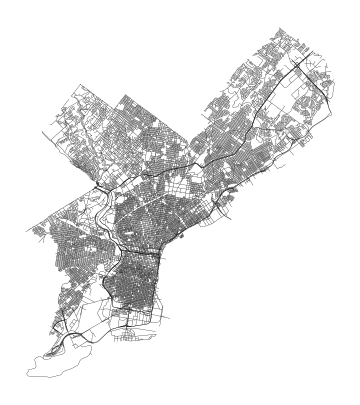

In [5]:
fig, ax = plt.subplots(figsize=(5,5))
ax.set_axis_off()

streets_granular.plot(ax=ax, edgecolor="black", linewidth=0.2)
plt.show()

## Bounding box for old city

In [6]:
bbox = box(-75.1662060,39.9411582, -75.1456557,39.9557201)
old_city = gpd.GeoSeries([bbox], crs="EPSG:4326").to_crs("EPSG:3857").iloc[0]

## Simplify and remove weird streets

In [7]:
clipped_streets = simplify_streets(
    streets_gdf   = streets_granular,
    clip_poly     = old_city,
    grid_size     = 30.0,
    rotation_deg  = 9.0,
    max_extend    = 50.0,
)

In [8]:
cx, cy = old_city.centroid.x, old_city.centroid.y

rotated_back = gpd.GeoSeries(
    [rotate(geom, -9.0, origin=(cx, cy)) for geom in clipped_streets.geometry],
    crs=clipped_streets.crs
)

# 3) set that GeoSeries as the active geometry
clipped_streets = clipped_streets.set_geometry(rotated_back)

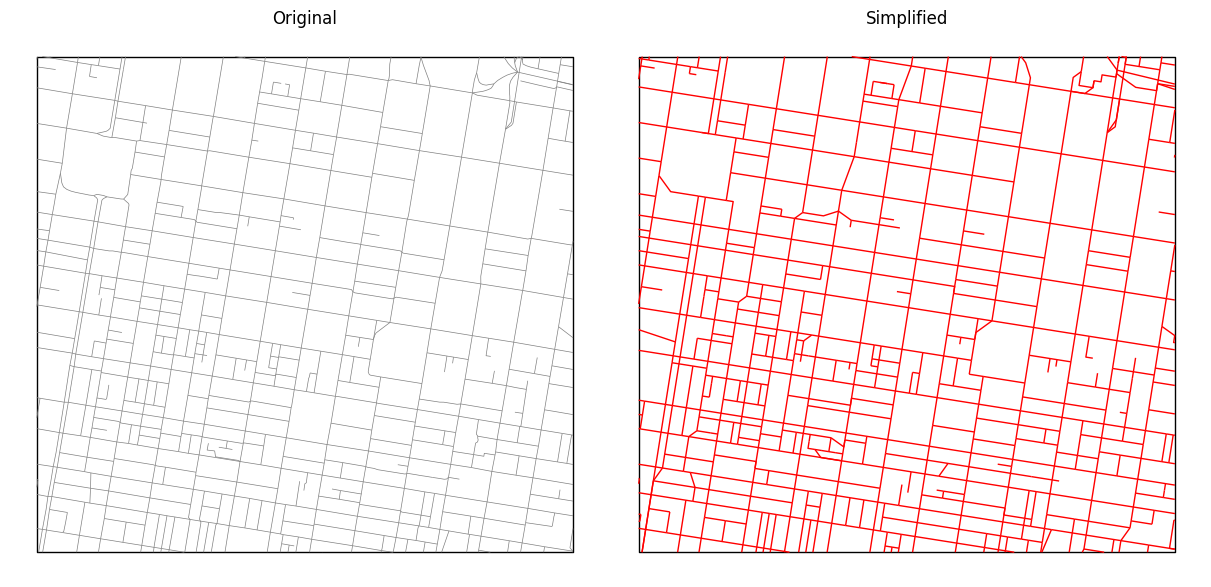

In [9]:
# plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
for ax in (ax1, ax2):
    ax.set_axis_off()

# original clipped
old_city = gpd.GeoSeries([bbox], crs="EPSG:4326").to_crs("EPSG:3857")

old_city.plot(ax=ax1, facecolor='none', edgecolor="black", linewidth=1)
streets_granular.clip(old_city).plot(ax=ax1, color="grey", linewidth=0.5)
ax1.set_title("Original")

# simplified + rotated back
old_city.plot(ax=ax2, facecolor='none', edgecolor="black", linewidth=1)
rotated_back.plot(ax=ax2, color="red", linewidth=1)
ax2.set_title("Simplified")

plt.show()

# Extract buildings in Philadelphia

In [10]:
west  = -75.16620602283949
south =  39.94115823455355
east  = -75.14565573634475
north =  39.955720193879245

bbox = (west, south, east, north)  # (left, bottom, right, top)

parks = ox.features_from_bbox(bbox=bbox, tags={"leisure": "park"}).to_crs("EPSG:3857")

# Obtain residential buildings
residential_tags = {
    "building": [
        "residential", 
        "house", 
        "hotel",
        "detached", 
        "semidetached_house", 
        "terrace", 
        "apartments", 
        "bungalow", 
        "dormitory", 
        "cabin",
        "farm"
    ]
}
homes = ox.features_from_bbox(bbox=bbox, tags=residential_tags).to_crs("EPSG:3857")
homes = homes[homes.geometry.apply(lambda geom: geom.geom_type in ['Polygon', 'MultiPolygon'])]

# Obtain retail buildings
retail_tags = {
    "building": [
        "retail",
        "shop",
        "supermarket",
        "mall",
        "department_store",
        "kiosk",
        "restaurant"
    ]
}
retail = ox.features_from_bbox(bbox=bbox, tags=retail_tags).to_crs("EPSG:3857")
retail = retail[retail.geometry.apply(lambda geom: geom.geom_type in ['Polygon', 'MultiPolygon'])]

# Obtain workplace buildings
workplace_tags = {
    "building": [
        "office",
        "industrial",
        "commercial",
        "public",
        "hospital",
        "school",
        "university",
        "government",
        "civic",
        "warehouse",
        "factory",
        "workshop",
    ]
}
workplaces = ox.features_from_bbox(bbox=bbox, tags=workplace_tags).to_crs("EPSG:3857")
workplaces = workplaces[workplaces.geometry.apply(lambda geom: geom.geom_type in ['Polygon', 'MultiPolygon'])]

# Obtain everything else as "other"
all_buildings = ox.features_from_bbox(bbox=bbox, tags={"building": True}).to_crs("EPSG:3857")
all_buildings = all_buildings[all_buildings.geometry.apply(lambda geom: geom.geom_type in ['Polygon', 'MultiPolygon'])]

q_work = "club == club or office==office or education==education or studio==studio"
workplaces = pd.concat([workplaces, all_buildings.query(q_work)]).drop_duplicates()

q_retail = "cuisine == cuisine or museum==museum or healthcare==healthcare"
retail = pd.concat([retail, all_buildings.query(q_retail)]).drop_duplicates()

q_homes = "residential == residential"
homes = pd.concat([homes, all_buildings.query(q_homes)]).drop_duplicates()

other_buildings = all_buildings.query("not (" + q_work + " or " + q_retail + " or " + q_homes+")")

In [11]:
# Save the data to GeoJSON files
parks.to_file("phl_parks_osmnx.geojson", driver="GeoJSON")
homes.to_file("phl_homes_osmnx.geojson", driver="GeoJSON")
retail.to_file("phl_retail_osmnx.geojson", driver="GeoJSON")
workplaces.to_file("phl_workplaces_osmnx.geojson", driver="GeoJSON")
other_buildings.to_file("phl_others_osmnx.geojson", driver="GeoJSON")

In [ ]:
# let's shuffle: club, office, education, studio ---> workplaces, cuisine, museum, healthcare ----> retail, residential -----> homes

### Rotate and clip buildings

In [12]:
rot_parks = parks.assign(geometry=parks.geometry.rotate(9, origin=(cx, cy)))
rot_parks = gpd.GeoDataFrame(rot_parks)
clipped_parks = gpd.clip(rot_parks, old_city)

rot_homes = homes.assign(geometry=homes.geometry.rotate(9, origin=(cx, cy)))
rot_homes = gpd.GeoDataFrame(rot_homes)
clipped_homes = gpd.clip(rot_homes, old_city)

rot_retail = retail.assign(geometry=retail.geometry.rotate(9, origin=(cx, cy)))
rot_retail = gpd.GeoDataFrame(rot_retail)
clipped_retail = gpd.clip(rot_retail, old_city)

rot_workplaces = workplaces.assign(geometry=workplaces.geometry.rotate(9, origin=(cx, cy)))
rot_workplaces = gpd.GeoDataFrame(rot_workplaces)
clipped_workplaces = gpd.clip(rot_workplaces, old_city)

rot_others = other_buildings.assign(geometry=other_buildings.geometry.rotate(9, origin=(cx, cy)))
rot_others = gpd.GeoDataFrame(rot_others)
clipped_others = gpd.clip(rot_others, old_city)

In [14]:
clipped_streets = simplify_streets(
    streets_gdf   = streets_granular,
    clip_poly     = old_city,
    grid_size     = 30.0,
    rotation_deg  = 9.0,
    max_extend    = 50.0,
)

/tmp/ipykernel_22106/1303021780.py:11: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  clip = clip_poly.unary_union if hasattr(clip_poly, "unary_union") else clip_poly


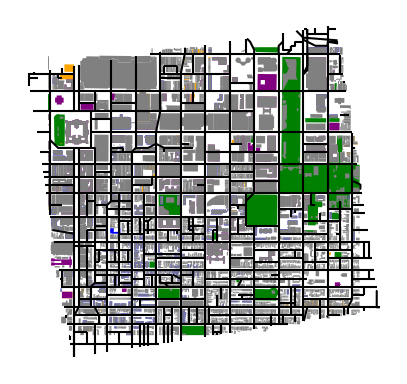

In [15]:
fig, ax = plt.subplots(figsize=(5,5))
ax.set_axis_off()

clipped_parks.plot(ax=ax,color="green")
clipped_homes.plot(ax=ax, color="blue")
clipped_retail.plot(ax=ax, color="orange")
clipped_workplaces.plot(ax=ax, color="purple")
clipped_others.plot(ax=ax, color="grey")

clipped_streets.plot(ax=ax,edgecolor="black")

plt.show()

- grid 10m x 10m ((i,j))
- streets = intersects with streets
- assign a street block to each non-street block or None # <<< sped up with spatial predicate
- iterate through each polygon, and group blocks that intersect  <<<< sped up with spatial predicate
- convert to gc tuples

In [16]:
import networkx as nx
from shapely.ops import unary_union
from scipy.ndimage import label

class RealCityGenerator:
    def __init__(self, 
                 city_bounds,
                 streets_gdf, 
                 parks_gdf=None,
                 homes_gdf=None,
                 retail_gdf=None,
                 workplaces_gdf=None,
                 other_buildings_gdf=None,
                 block_size=10):
        
        self.city_bounds = city_bounds
        self.streets_gdf = streets_gdf

        self.parks_gdf = parks_gdf
        self.homes_gdf = homes_gdf
        self.retail_gdf = retail_gdf
        self.workplaces_gdf = workplaces_gdf
        self.other_buildings_gdf = other_buildings_gdf

        self.block_size = block_size
        self.city = City(dimensions=self._get_dimensions(),
                         manual_streets=True)
        self._create_grid()

    def _get_dimensions(self):
        self.minx, self.miny, self.maxx, self.maxy = self.city_bounds.total_bounds
        self.width = int((self.maxx - self.minx) // self.block_size)
        self.height = int((self.maxy - self.miny) // self.block_size)
        return (self.width, self.height)

    def _create_grid(self):
        # Maps grid cell coordinates to geometries
        self.grid_coords = []
        for i in range(self.width):
            for j in range(self.height):
                cell = box(self.minx + i * self.block_size, self.miny + j * self.block_size,
                           self.minx + (i + 1) * self.block_size, self.miny + (j + 1) * self.block_size)
                self.grid_coords.append((i, j, cell))

        # Label grid cells according to their type
        # 0: undefined, 1: street, 2: building
        self.grid_labels = np.zeros((self.width, self.height), dtype=np.int8)
        for i, j, cell_geom in self.grid_coords:
            if self._is_street(cell_geom):
                self.grid_labels[i, j] = 1
                self.city.add_street((i, j))

    def _is_street(self, cell_geom):
        # Returns True if cell intersects any street geometry
        return self.streets_gdf.intersects(cell_geom).any()
    
    def _get_adjacent_street_block(self, x, y):
        """
        Returns the coordinates of an adjacent street block for a non-street cell (x, y).
        If no adjacent street block exists, returns None.
        """
        for dx, dy in [(0,-1), (0,1), (-1,0), (1,0)]:
            nx_, ny_ = x + dx, y + dy
            if 0 <= nx_ < self.width and 0 <= ny_ < self.height:
                if self.grid_labels[nx_, ny_] == 1:
                    return (nx_, ny_)
        return None

    def compute_adjacent_streets(self):
        """
        Computes and stores a dictionary mapping each non-street cell (x, y)
        to the coordinates of an adjacent street block (or None if none exists).

        gpd_df.touches(streets) <<<<<
        """
        self.adjacent_streets = {}
        for i in range(self.width):
            for j in range(self.height):
                if self.grid_labels[i, j] != 1:
                    self.adjacent_streets[(i, j)] = self._get_adjacent_street_block(i, j)

    def _add_buildings_from_gdf(self, gdf, building_type, verbose=False):
        # For each building geometry, find all grid cells it covers and add as a Building
        for _, building_geom in gdf.geometry.items():
            covered_cells = []
            # First, get rough search area using bounding box of building
            minx, miny, maxx, maxy = building_geom.bounds
            imin = max(0, int((minx - self.minx) // self.block_size))
            imax = min(self.width, int((maxx - self.minx) // self.block_size) + 1)
            jmin = max(0, int((miny - self.miny) // self.block_size))
            jmax = min(self.height, int((maxy - self.miny) // self.block_size) + 1)
            possible_cells = [
                (x, y, cell_geom)
                for x, y, cell_geom in self.grid_coords
                if (imin <= x < imax) and (jmin <= y < jmax) and building_geom.intersects(cell_geom)
            ]
            for x, y, _ in possible_cells:
                if self.grid_labels[x, y] == 0:
                    covered_cells.append((x, y))
            if covered_cells:
                # Sometimes, a building may cover multiple non-contiguous blocks
                # Find clusters of contiguous blocks in covered_cells
                mask = np.zeros((self.width, self.height), dtype=bool)
                for x, y in covered_cells:
                    mask[x, y] = True

                labeled, num_features = label(mask)
                clusters = []
                for k in range(1, num_features + 1):
                    cluster = [(ix, iy) for ix in range(self.width) for iy in range(self.height) if labeled[ix, iy] == k]
                    clusters.append(cluster)

                for cluster_cells in clusters:
                    door = None
                    for x, y in cluster_cells:
                        if (x, y) in self.adjacent_streets and self.adjacent_streets[(x, y)] is not None:
                            door = self.adjacent_streets[(x, y)]
                            try:
                                self.city.add_building(building_type=building_type,
                                                       door=door,
                                                       blocks=cluster_cells)
                                break
                            except ValueError as e:
                                if verbose:
                                    print(f"Error adding building of type {building_type}: {e}")

    def add_all_buildings(self):
        if self.parks_gdf is not None:
            self._add_buildings_from_gdf(self.parks_gdf, "park")
        if self.homes_gdf is not None:
            self._add_buildings_from_gdf(self.homes_gdf, "home")
        if self.workplaces_gdf is not None:
            self._add_buildings_from_gdf(self.workplaces_gdf, "work")
        if self.retail_gdf is not None:
            self._add_buildings_from_gdf(self.retail_gdf, "retail")
        if self.other_buildings_gdf is not None:
            self._add_buildings_from_gdf(self.other_buildings_gdf, "other")
        self.city.get_street_graph()

    def generate_city(self):
        self.compute_adjacent_streets()
        self.add_all_buildings()

In [17]:
%%time

Old_City_Philly = RealCityGenerator(
    city_bounds=old_city,
    streets_gdf=clipped_streets,
    parks_gdf=clipped_parks,
    homes_gdf=clipped_homes,
    retail_gdf=clipped_retail,
    workplaces_gdf=clipped_workplaces,
    other_buildings_gdf=clipped_others,
    block_size=15
)
Old_City_Philly.generate_city()

city = Old_City_Philly.city

In [16]:
#city.save('../philadelphia-old-city.pkl')

Plot city

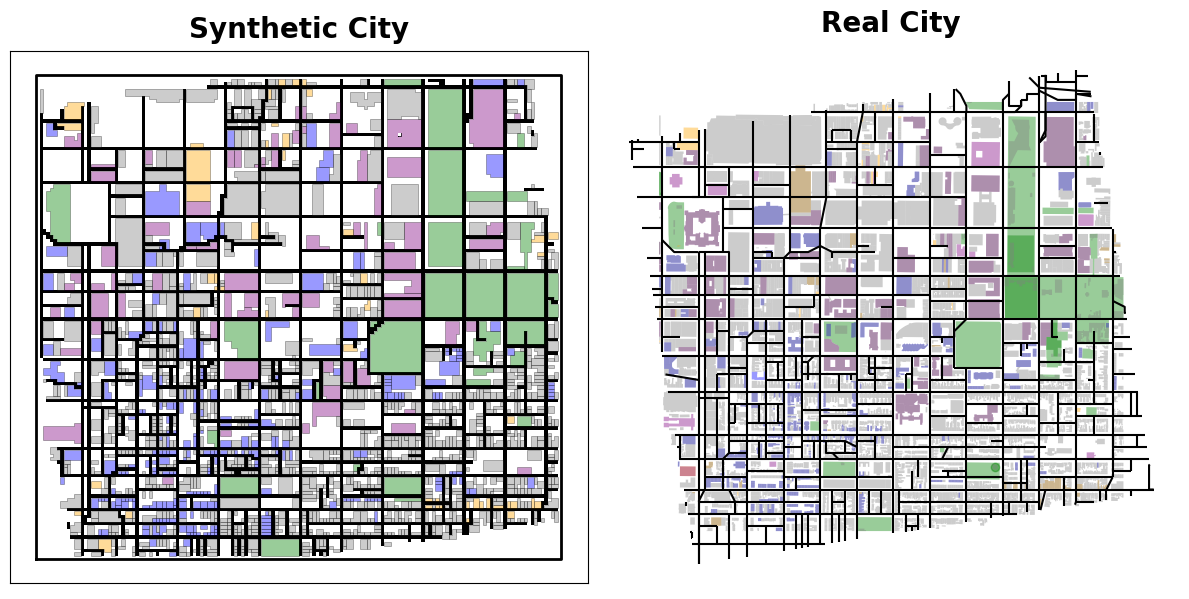

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

colors = {
    'street': 'black',
    'home': 'blue',
    'work': 'purple',
    'retail': 'orange',
    'park': 'green',
    'default': 'grey'
}

# Left: city grid
ax1.set_title("Synthetic City", fontsize=20, pad=10, fontweight='bold')
city.plot_city(ax1, doors=False, address=False, colors=colors, alpha=0.4)
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.set_xticks([])
ax1.set_yticks([])

# Right: clipped buildings and streets
ax2.set_title("Real City", fontsize=20, pad=10, fontweight='bold')
ax2.set_axis_off()
clipped_parks.plot(ax=ax2, color="green", alpha=0.4)
clipped_homes.plot(ax=ax2, color="blue", alpha=0.4)
clipped_retail.plot(ax=ax2, color="orange", alpha=0.4)
clipped_workplaces.plot(ax=ax2, color="purple", alpha=0.4)
clipped_others.plot(ax=ax2, color="grey", alpha=0.4)

clipped_streets.plot(ax=ax2, edgecolor="black")

plt.tight_layout()
#plt.savefig("synthetic-philly.png", dpi=800, bbox_inches='tight')
#plt.savefig("synthetic-philly.svg")
plt.show()

In [19]:
agent = Agent(
    identifier="Charlie",
    city=city,
    seed=1
)
agent.generate_trajectory(
    datetime = "2024-01-01T08:00 -04:00",
    end_time = pd.Timestamp('2024-01-21T08:30:00 -04:00'),
    seed=1,
    dt=1)

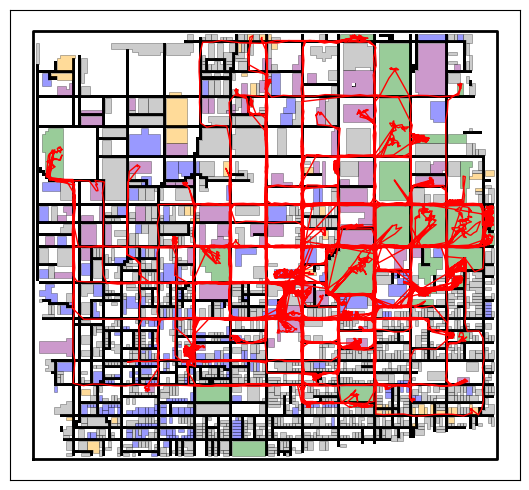

In [21]:
fig, ax = plt.subplots(figsize=(9, 5))

city.plot_city(ax, doors=False, address=False, colors=colors, alpha=0.4)
ax.plot(agent.trajectory.x,
        agent.trajectory.y,
        linewidth=1, color='red', alpha=1)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.savefig("agent-in-philly.png", dpi=300, bbox_inches='tight')
plt.show()